# The main result

In [1]:
import matplotlib
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
%matplotlib inline

from IPython.display import display

PATH = os.path.abspath('../..')

# Plotting helper function

In [2]:
mad = lambda x: np.median(np.abs(x - np.median(x)))

def nmad(z, const=1.4826):
    """Returns the Gaussian sigma according to MAD"""
    return const*mad(z)

In [3]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [18]:
# define colors, selecting using colorblind-friendly picker at 
# https://colorcyclepicker.mpetroff.net/
c_nmad = '#8888ed'
c_median = '#ce1504'
c_rmse = '#ce1504'

In [20]:
def plot_comparison_with_marginals(y_test, p_test, sz=128, which='metallicity', figname=None):
    
    if which == 'metallicity':
        bmin, bmax, step = 8.2, 9.3, 0.1
        xlabel = r'$Z_{\rm true}$'
        ylabel = r'$Z_{\rm pred}$'
        if sz < 8:
            max_scatter = 0.5
        else:
            max_scatter = 0.3
    elif which == 'mass':
        bmin, bmax, step = 8.4, 11.2, 0.2
        xlabel = r'M_{\ast,\rm\,true}'
        ylabel = r'M_{\ast,\rm\,pred}'
        max_scatter = 0.6
    
    gs = matplotlib.gridspec.GridSpec(20, 20)   
    fig = plt.figure(figsize=(8, 8))
    
    ax = fig.add_subplot(gs[4:, 2:18])
    
    # plot main histogram
    cmap = truncate_colormap(plt.cm.Greys, 0.1, 0.8,)
    cmap.set_bad('white', 1.)
    *_, im = ax.hist2d(y_test, p_test, bins=100, range=[[bmin, bmax], [bmin, bmax]], 
                       cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=1, vmax=100, clip=True)
                      )
              
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    
    #ax.text(bmin + 0.05, bmax - step, r'${} \times {}$'.format(sz, sz), fontsize=16)
    
    # add colorbar
    ax_cb = fig.add_subplot(gs[4:, 18:19])
    cb = fig.colorbar(im, cax=ax_cb);
    cb.set_label('Number of galaxies', fontsize=16)   
    cb.ax.set_yticklabels([1] + ['']*8 + [10] + ['']*8 + [100])
    
    # add top margin plot
    ax_marg = fig.add_subplot(gs[:4, 2:18])

    y_bins = np.arange(bmin, bmax, step)
    rmse_bins = np.array([np.sqrt(np.mean(((p_test - y_test)[(y_test > y - step/2) & (y_test < y + step/2)])**2)) for y in y_bins])
    num_in_bins = np.sum([(y_test > y - step/2) & (y_test < y + step/2) for y in y_bins], axis=1)
    rmse_error = np.sqrt(np.mean(((p_test - y_test)**2)))
    ax_marg.scatter(y_bins, rmse_bins, marker='o', c=c_rmse, s=num_in_bins/25, label=f'RMSE = {rmse_error:.4f}', zorder=2, edgecolor='white')

    nmad_bins = np.array([nmad(((p_test - y_test)[(y_test > y - step/2) & (y_test < y + step/2)])) for y in y_bins])
    nmad_error = nmad(p_test - y_test)
    
    ax_marg.scatter(y_bins, nmad_bins, marker='o', c=c_nmad, s=num_in_bins/25, label=f'NMAD = {nmad_error:.4f}', zorder=1, edgecolor='white')
    
    #ax_marg.set_ylabel('Residual\nscatter', fontsize=14)
    ax_marg.set_ylabel(r'Scatter', fontsize=16)
    ax_marg.legend(fontsize=14, framealpha=0.0, frameon=False, loc='upper right')
    ax_marg.set_ylim(0, max_scatter)
    ax_marg.set_xlim(bmin, bmax)
    ax_marg.set_xticklabels([])
    
    # include mean RMSE  
    ax_marg.axhline(rmse_error, ls='-', lw=4, c=c_rmse, zorder=0)
    ax_marg.axhline(nmad_error, ls='-', lw=4, c=c_nmad, zorder=0)
    
    # running median + std/MAD on main figure
    running_median = np.array([np.median(p_test[(y_test > y - step/2) & (y_test < y + step/2)]) for y in y_bins])
    ax.plot(y_bins, running_median, c=c_median, lw=4, label='Median')
    ax.plot(y_bins, running_median + rmse_bins, c=c_rmse, ls='--', lw=4, label=r'$\pm 1$ RMSE', zorder=3)
    ax.plot(y_bins, running_median - rmse_bins, c=c_rmse, ls='--', lw=4, zorder=3)
    ax.plot(y_bins, running_median + nmad_bins, c=c_nmad, ls='--', lw=4, label=r'$\pm 1$ NMAD', zorder=2)
    ax.plot(y_bins, running_median - nmad_bins, c=c_nmad, ls='--', lw=4, zorder=2)
    
    # one-to-one line on main figure
    ax.plot([bmin, bmax], [bmin, bmax], c='k', ls='-', lw=4, zorder=1, alpha=0.8, label=r'$Z_{\rm pred} = Z_{\rm true}$')    
    
    ax.legend(loc='lower right', fontsize=14, frameon=False)
    
    fig.subplots_adjust(left=0.025, right=0.925, bottom=0.075, top=0.975)
    

    if not figname:
        fig.savefig(f'{PATH}/results/single-sz{sz}_{which}_pred-vs-SDSS_with-marginals.pdf', dpi=300)
    else:
        fig.savefig(figname, dpi=300)
        
    return fig
    


# Plot $128 \times 128$ prediction results

In [6]:
preds = pd.read_csv(f'{PATH}/catalogs/predictions-oh_p50.csv', index_col=0)
preds.head()

,oh_p50,prediction
objID,,
1237658493878337647,8.577997,8.696861
1237665330918850673,8.726439,8.757436
1237657630582178125,8.948060,9.024221
1237651250411405534,8.894798,9.015285
1237674651536261211,8.333275,8.544479


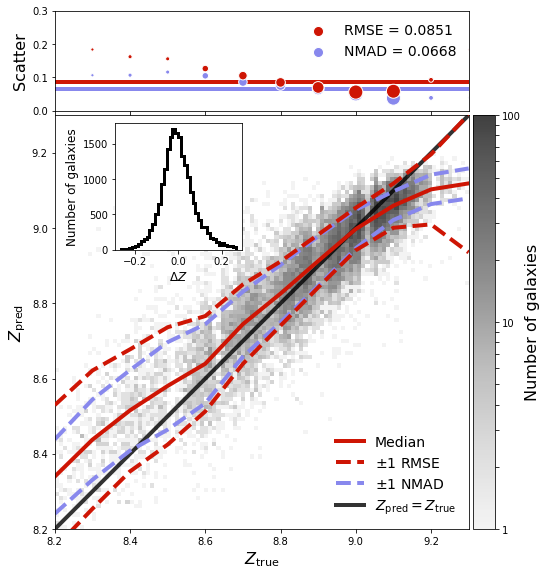

In [21]:
fig = plot_comparison_with_marginals(preds.oh_p50, preds.prediction, sz=128,
                                     figname=f'{PATH}/results/02-prediction_summary.pdf'
                                    )

# residuals
res = preds.prediction - preds.oh_p50
binsize_res = 2 * (res.quantile(0.75) - res.quantile(0.25)) * res.size**(-1/3)

bins = 40
histrange_res = [-bins * binsize_res, bins * binsize_res]

ax_inset = fig.add_axes([0.22, 0.56, 0.22, 0.22])

n, bin_edges, _ = ax_inset.hist(res, bins=bins, range=histrange_res, color='k', histtype='step', lw=3)

ax_inset.set_xlabel('$\Delta Z$', fontsize=12)
ax_inset.set_ylabel('Number of galaxies', fontsize=12)

fig.savefig(f'{PATH}/results/02-prediction_summary.pdf')